# Stock Price Movement Prediction
## Objective
Predict whether the closing price of an S&P 500 stock will increase or decrease on the next trading day based on the following features:
- Opening Price
- Highest Price
- Lowest Price
- Adjusted Close Price
- Trading Volume

## Data Description
- **Date Range**: 2010 to end of 2016
- **Companies**: 501 S&P 500 companies
- **Data Points**: 851,264 entries
- **Adjustments**: 140 stock splits adjusted in `prices-split-adjusted.csv`


## Importing Necessary Libraries
We'll import only the essential libraries required for data manipulation, visualization, and modeling with LSTM.

In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report, roc_curve

# Deep Learning with TensorFlow and Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set plot aesthetics
sns.set_theme(style="whitegrid", palette="muted")
%matplotlib inline

## Loading and Inspecting the Data
We'll load the dataset, inspect the first few rows, check for missing values, and understand the data types.

In [2]:
# Load the dataset
df = pd.read_csv('../data/raw/prices-split-adjusted.csv')

df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [3]:
# Check the data types and non-null counts
print("\nData Information:")
df.info()


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [4]:
# Check unique values
print("\nUnique Values per Column:")
df.nunique()


Unique Values per Column:


date        1762
symbol       501
open       97522
close      98520
low        97470
high       97784
volume    171073
dtype: int64

## Data Preprocessing
Handle missing values, create the target variable, and perform necessary feature engineering.

### Handling Missing Values
We'll impute missing values (if any) for numerical columns using the median strategy.

In [5]:
# Check for missing values
print("\nMissing Values per Column:")
df.isnull().sum()


Missing Values per Column:


date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64

In [6]:
# Check for missing values
missing = df.isnull().sum()
missing_cols = missing[missing > 0]

if not missing_cols.empty:
    print("\nMissing Values:")
    print(missing_cols)

    # Impute missing values for numerical columns using median
    numerical_cols = ['open', 'close', 'low', 'high', 'volume']
    imputer = SimpleImputer(strategy='median')
    df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

    # Verify no missing values remain
    print("\nMissing Values After Imputation:")
    print(df.isnull().sum())
else:
    print("\nNo missing values found. Skipping imputation.")


No missing values found. Skipping imputation.


### Feature Engineering
Create additional features that may help in prediction.

In [7]:
# Create daily return as a feature
df['daily_return'] = (df['close'] - df['open']) / df['open']

# Create volatility feature
df['volatility'] = (df['high'] - df['low']) / df['open']

# Drop any remaining missing values just in case
df = df.dropna()

print("\nData with new features:")
display(df.head())


Data with new features:


,date,symbol,open,close,low,high,volume,daily_return,volatility
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,0.019525,0.031921
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,-0.041999,0.044714
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,-0.012287,0.041330
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,0.009872,0.034118
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,-0.017434,0.027690


### Defining the Target Variable
We'll create a binary target variable indicating whether the closing price increases (1) or decreases (0) the next trading day.

In [8]:
# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'])

# Sort the dataframe by symbol and date to ensure correct ordering
df = df.sort_values(by=['symbol', 'date'])

# Create the target variable: 1 if next day's close > today's close, else 0
df['target'] = df.groupby('symbol')['close'].shift(-1) > df['close']
df['target'] = df['target'].astype(int) # Convert Target to Binary (1 or 0)

# Drop the last day for each symbol as it doesn't have a target
df = df.dropna(subset=['target'])

# Verify target distribution
print("Target distribution:\n", df['target'].value_counts())

Target distribution:
 target
1    438931
0    412333
Name: count, dtype: int64


In [9]:
print("\nSample data with target variable:")
df.head(10)


Sample data with target variable:


,date,symbol,open,close,low,high,volume,daily_return,volatility,target
251,2010-01-04,A,22.453504,22.389128,22.267525,22.625180,3815500.0,-0.002867,0.015929,0
718,2010-01-05,A,22.324749,22.145923,22.002861,22.331903,4186000.0,-0.008010,0.014739,0
1186,2010-01-06,A,22.067240,22.067240,22.002861,22.174536,3243700.0,0.000000,0.007780,0
1654,2010-01-07,A,22.017168,22.038626,21.816881,22.045780,3095100.0,0.000975,0.010396,0
2122,2010-01-08,A,21.917024,22.031474,21.745350,22.067240,3733900.0,0.005222,0.014687,1
2590,2010-01-11,A,22.088697,22.045780,21.938484,22.210300,4781500.0,-0.001943,0.012306,0
3058,2010-01-12,A,21.859800,21.781117,21.616594,21.924177,2871000.0,-0.003599,0.014071,1
3526,2010-01-13,A,21.795421,21.952789,21.494994,22.017168,3418900.0,0.007220,0.023958,1
3994,2010-01-14,A,21.881258,22.281832,21.816881,22.346209,6163700.0,0.018307,0.024191,0
4462,2010-01-15,A,22.331903,21.766810,21.695278,22.432045,4626600.0,-0.025304,0.032992,1


## Exploratory Data Analysis (EDA)
Understand the distribution of features and the target variable.

### Distribution of the Target Variable

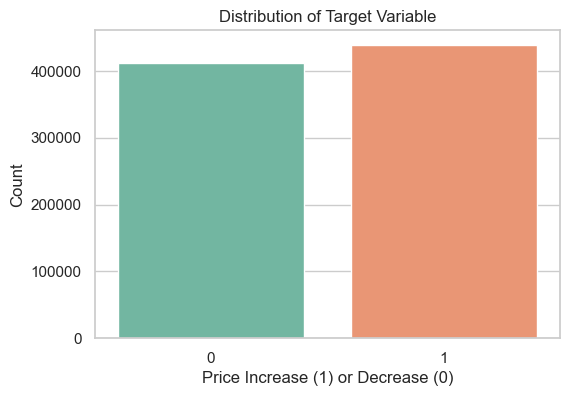


Class Distribution:
target
1    0.515623
0    0.484377
Name: proportion, dtype: float64


In [10]:
# Plot the distribution of the target variable
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=df, palette='Set2')
plt.title('Distribution of Target Variable')
plt.xlabel('Price Increase (1) or Decrease (0)')
plt.ylabel('Count')
plt.show()

# Print the class balance
print("\nClass Distribution:")
print(df['target'].value_counts(normalize=True))

### Feature Distributions
Visualize the distribution of key numerical features.

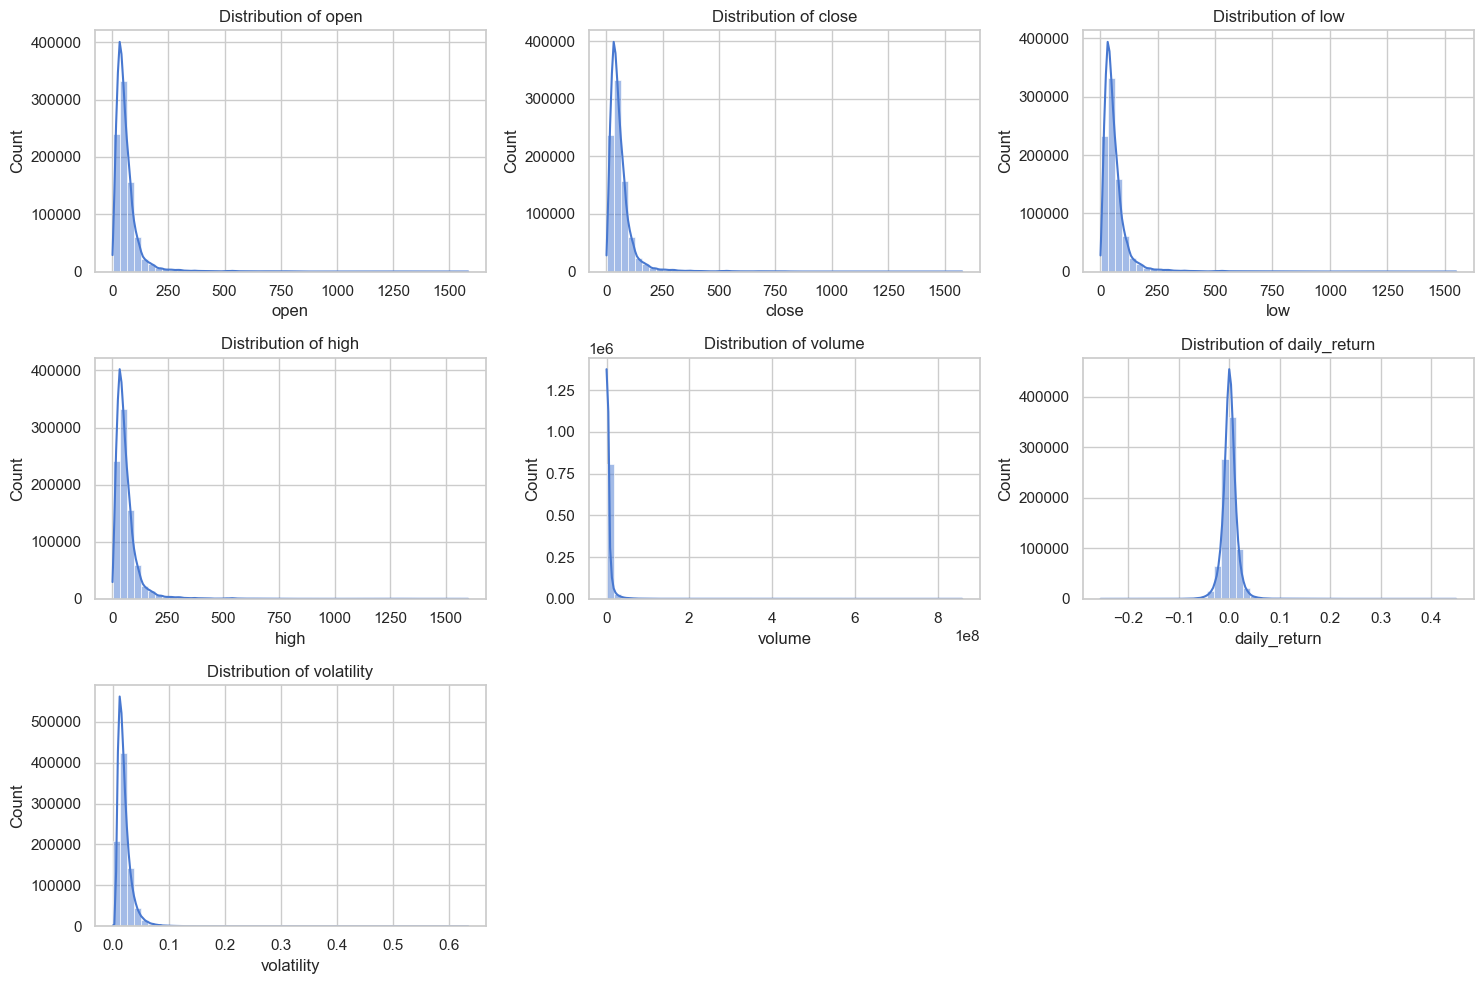

In [11]:
# Select numerical features for plotting
features = ['open', 'close', 'low', 'high', 'volume', 'daily_return', 'volatility']

# Plot histograms
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[feature], kde=True, bins=50)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

#### Observation:

- **Open, Close, Low, High Prices:**
  - These features are heavily skewed to the right, with most values clustered in the lower range. We might need to scale or transform them (maybe with log scaling) to handle the skew if it impacts the model.

- **Volume:**
  - Trading volume is also very right-skewed, with a few really high values standing out as potential outliers. We’ll probably need to normalize this or deal with those outliers.

- **Daily Return:**
  - This one’s more balanced, with a nice symmetric distribution around zero. It looks like we have a good mix of small positive and negative returns.

- **Volatility:**
  - Volatility is skewed to the right, with most values near zero. Big price swings within a day seem to be rare.

### Correlation Analysis
Examine the correlation between features and the target variable.

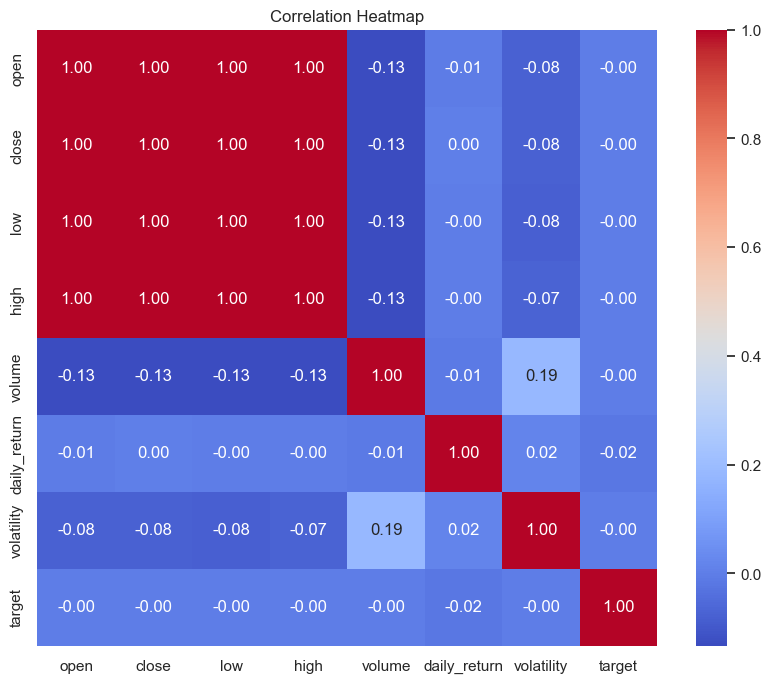

In [12]:
# Compute the correlation matrix
corr_matrix = df[['open', 'close', 'low', 'high', 'volume', 'daily_return', 'volatility', 'target']].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

#### Observation:

- The `open`, `close`, `low`, and `high` prices are nearly perfectly correlated (1.00). We don’t need to include all of them since they basically carry the same information.

- `Daily Return` and `Volatility` don’t have strong correlations with the other features, so they might bring some unique value to the model.

- The `target` variable doesn’t show strong correlations with any of the features, which is expected for financial data. It means the model will have to work harder to find patterns.

## Data Preparation
Split the data into training and testing sets, and scale the features.

### Sequence Generation for LSTM
LSTM models require input data in the form of sequences. We'll define a `lookback period` (number of previous days) to create these sequences.

In [13]:
def create_sequences(df, lookback):
    """
    Create sequences of data for LSTM.

    Parameters:
    - df: pandas DataFrame
    - lookback: int, number of previous days to include in each sequence

    Returns:
    - X: numpy array of shape (samples, lookback, features)
    - y: numpy array of shape (samples,)
    """
    X, y = [], []
    symbols = df['symbol'].unique()
    
    for symbol in symbols:
        symbol_df = df[df['symbol'] == symbol].sort_values('date')
        data = symbol_df[['open', 'close', 'low', 'high', 'volume', 'daily_return', 'volatility']].values
        target = symbol_df['target'].values
        
        for i in range(len(data) - lookback):
            X.append(data[i:i+lookback])
            y.append(target[i+lookback])
    
    return np.array(X), np.array(y)

# Define the lookback period
LOOKBACK = 10

# Create sequences
X, y = create_sequences(df, LOOKBACK)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (846254, 10, 7)
Shape of y: (846254,)


### Splitting Data into Training and Testing Sets
We'll split the data based on chronological order to prevent data leakage. Training data will consist of sequences ending before 2016, and testing data will consist of sequences ending in 2016.

In [17]:
# Convert sequences back to DataFrame to access dates
def get_sequence_end_dates(df, lookback):
    """
    Get the end dates for each sequence.

    Parameters:
    - df: pandas DataFrame
    - lookback: int

    Returns:
    - dates: list of datetime objects
    """
    dates = []
    symbols = df['symbol'].unique()
    
    for symbol in symbols:
        symbol_df = df[df['symbol'] == symbol].sort_values('date')
        for i in range(lookback, len(symbol_df)):
            dates.append(symbol_df.iloc[i]['date'])
    
    return dates

sequence_dates = get_sequence_end_dates(df, LOOKBACK)

# Convert to pandas Series for easier indexing
sequence_dates = pd.Series(sequence_dates)

# Define the split date
split_date = pd.to_datetime('2016-01-01')

# Create boolean masks Train: (2010-2015) , Test: (2016)
train_mask = sequence_dates < split_date
test_mask = sequence_dates >= split_date

# Split the data
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (720149, 10, 7)
Testing set size: (126105, 10, 7)


### Scaling Features
We'll scale numerical features to ensure they contribute equally to the model. Scaling is performed based on the training data to prevent data leakage.

In [18]:
# Initialize StandardScaler
scaler = StandardScaler()

# Reshape X_train and X_test to 2D for scaling
num_samples_train, timesteps, num_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, num_features)
X_test_reshaped = X_test.reshape(-1, num_features)

# Fit the scaler on training data and transform both training and testing data
scaler.fit(X_train_reshaped)
X_train_scaled = scaler.transform(X_train_reshaped).reshape(num_samples_train, timesteps, num_features)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape[0], LOOKBACK, num_features)

print("\nFeatures scaled using StandardScaler.")


Features scaled using StandardScaler.


## Building the LSTM Model
We'll construct an LSTM-based neural network for binary classification.

In [19]:
# Define the LSTM model
model = Sequential([
    LSTM(64, input_shape=(LOOKBACK, X_train_scaled.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            18432     
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 31393 (122.63 KB)
Trainable params: 31393 

## Training the Model
We'll train the LSTM model with early stopping to prevent overfitting.

In [20]:
# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
4501/4501 [==============================] - 43s 9ms/step - loss: 0.6923 - accuracy: 0.5163 - val_loss: 0.6915 - val_accuracy: 0.5193
Epoch 2/50
4501/4501 [==============================] - 41s 9ms/step - loss: 0.6909 - accuracy: 0.5186 - val_loss: 0.6899 - val_accuracy: 0.5212
Epoch 3/50
4501/4501 [==============================] - 42s 9ms/step - loss: 0.6895 - accuracy: 0.5215 - val_loss: 0.6885 - val_accuracy: 0.5247
Epoch 4/50
4501/4501 [==============================] - 42s 9ms/step - loss: 0.6879 - accuracy: 0.5243 - val_loss: 0.6872 - val_accuracy: 0.5249
Epoch 5/50
4501/4501 [==============================] - 41s 9ms/step - loss: 0.6864 - accuracy: 0.5260 - val_loss: 0.6858 - val_accuracy: 0.5268
Epoch 6/50
4501/4501 [==============================] - 46s 10ms/step - loss: 0.6846 - accuracy: 0.5286 - val_loss: 0.6843 - val_accuracy: 0.5290
Epoch 7/50
4501/4501 [==============================] - 47s 11ms/step - loss: 0.6833 - accuracy: 0.5304 - val_loss: 0.6837 - val_

### Plotting Learning Curves
Visualizing training and validation loss and accuracy over epochs.

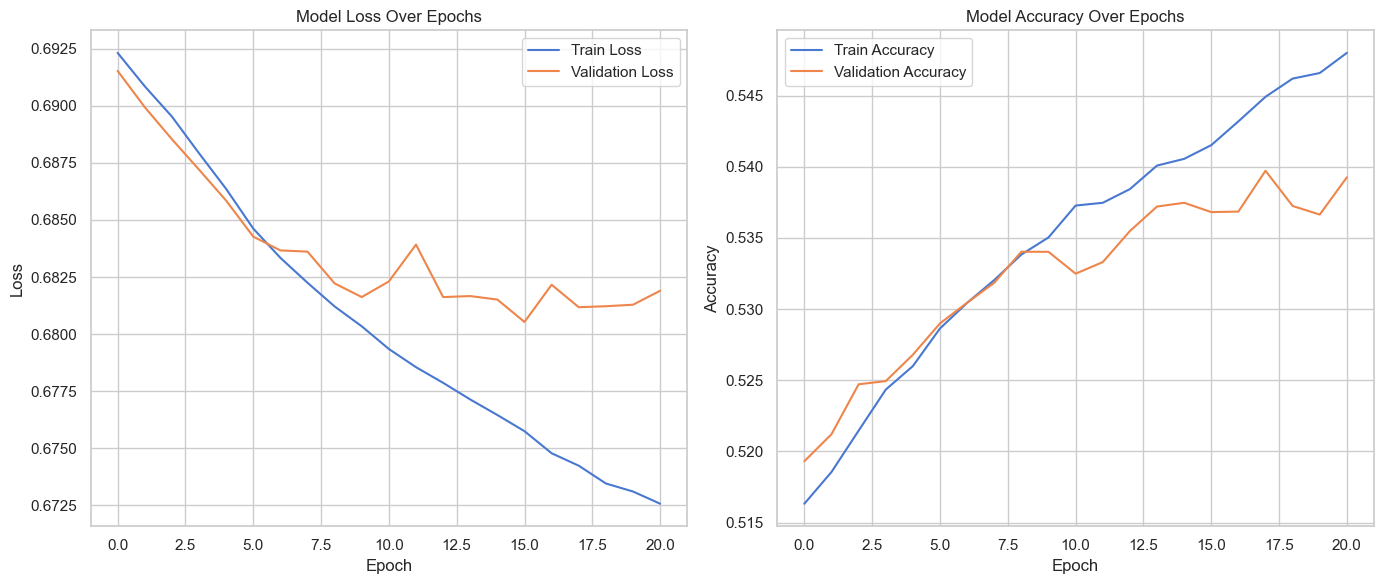

In [21]:
# Plot training & validation loss values
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

### Model Evaluation
We'll evaluate the performance of the LSTM model using various classification metrics and visualizations.

In [22]:
# Predict probabilities and classes
y_pred_proba = model.predict(X_test_scaled).flatten()
y_pred = (y_pred_proba >= 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Create a DataFrame to display metrics
evaluation_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'],
    'Score': [accuracy, precision, recall, f1, roc_auc]
})

print("\nModel Evaluation Metrics on Test Set:")
display(evaluation_metrics)

3941/3941 [==============================] - 4s 973us/step

Model Evaluation Metrics on Test Set:


,Metric,Score
0,Accuracy,0.506078
1,Precision,0.519686
2,Recall,0.696934
3,F1 Score,0.595398
4,ROC-AUC,0.495089


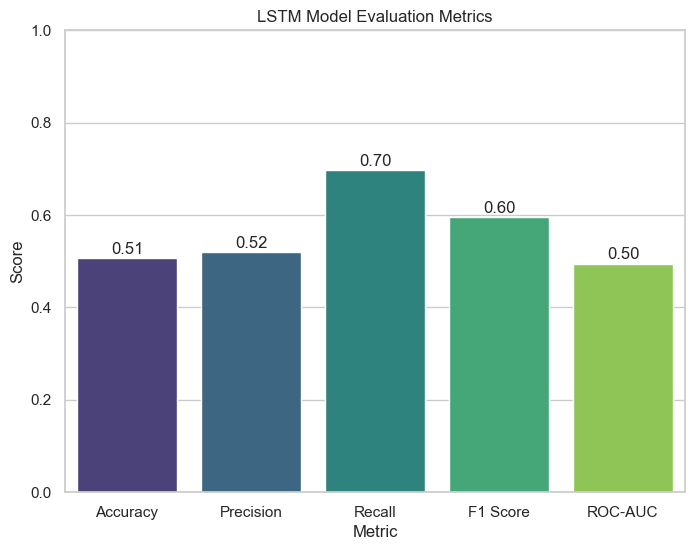

In [23]:
# Plot evaluation metrics
plt.figure(figsize=(8,6))
sns.barplot(x='Metric', y='Score', data=evaluation_metrics, palette='viridis')
plt.title('LSTM Model Evaluation Metrics')
plt.ylim(0, 1)
for index, row in evaluation_metrics.iterrows():
    plt.text(index, row.Score + 0.01, f"{row.Score:.2f}", ha='center')
plt.show()

### Confusion Matrix
Visualizing the confusion matrix to understand the distribution of predictions.

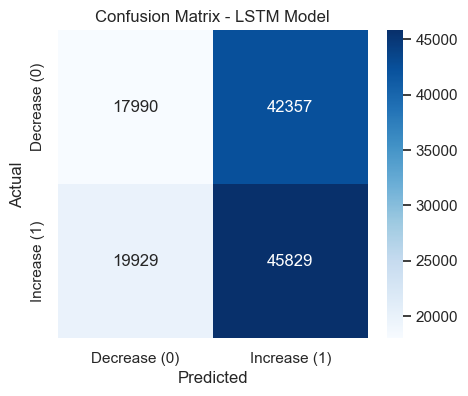

In [24]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Decrease (0)', 'Increase (1)'], yticklabels=['Decrease (0)', 'Increase (1)'])
plt.title('Confusion Matrix - LSTM Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### ROC Curve
Plotting the ROC curve to visualize the trade-off between true positive rate and false positive rate.

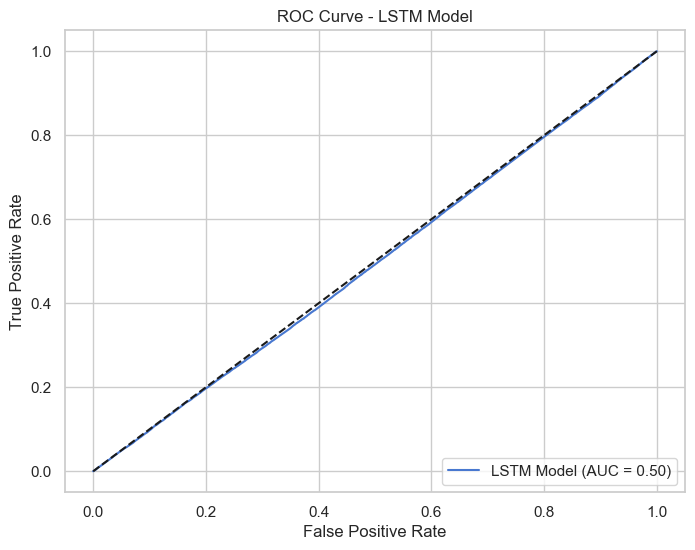

In [25]:
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'LSTM Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC Curve - LSTM Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Classification Report
Detailed classification report for the model.

In [26]:
# Print classification report
print("\nClassification Report for LSTM Model:")
print(classification_report(y_test, y_pred))


Classification Report for LSTM Model:
              precision    recall  f1-score   support

           0       0.47      0.30      0.37     60347
           1       0.52      0.70      0.60     65758

    accuracy                           0.51    126105
   macro avg       0.50      0.50      0.48    126105
weighted avg       0.50      0.51      0.49    126105



## Conclusion
